# This data analysis reviews SAT data on high schools from NYC Open Data
## This is a partially 'guided project' with DataQuest. I clearly identify the point after which I explore on my own

This project demonstrates familiarity with pandas, data manipulation, imputation, and basic analysis

-Leo Rozenfeld 11 Jan 2021

# Read in the data

In [92]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [93]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [94]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [95]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [96]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [97]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [98]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [99]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [100]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64
SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                             

# Plotting survey correlations

In [101]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Plot the correlations

<AxesSubplot:>

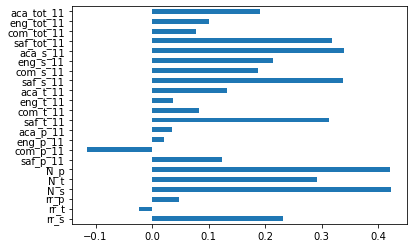

<AxesSubplot:>

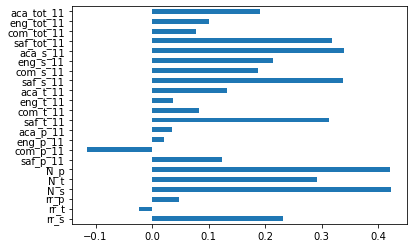

In [102]:
correlations[survey_fields].plot(kind='barh')

### Comments
Looking at the largest correlations visually,
here are strong correlations with saf_tot, aca_s_11, saf_s_11, saf_t_11, N_p, N_t, n_s (explored before)

This corresponds to
saf_tot = safety and respect total score
aca_s = academic expectations based on student responses
saf_s = safety and respect score based on student responses
saf_t = safety and respect score based on teacher responses
N_p = number of parent responders
N_t = number of teacher respondents
N_s = number of student responders



In [103]:
correlations[survey_fields].sort_values(ascending=False)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
eng_t_11      0.036906
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
Name: sat_score, dtype: float64

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
eng_t_11      0.036906
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
Name: sat_score, dtype: float64

Soring in descending order, The top criteria come out to be the response number, safety, and students' academic expectations (r approx >=0.3)

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

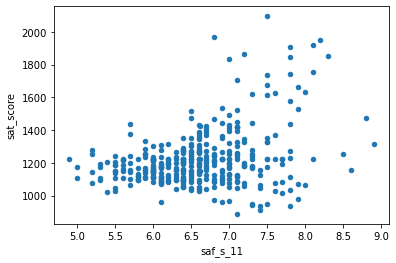

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

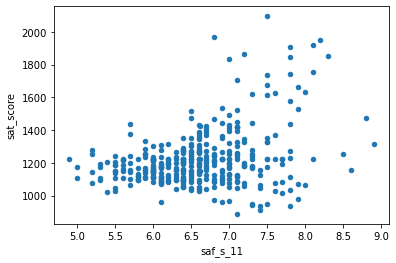

In [104]:
#plot scatter comparison of safety students vs sat score

combined.plot.scatter(x='saf_s_11', y='sat_score')

There is some positive correlation regarding safety scores, generally higher scores do seem to correspond to higher safety indices,
but at the lower end (up to about 7) it appears to have little difference

<AxesSubplot:ylabel='borough'>

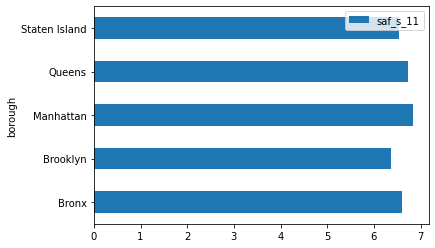

<AxesSubplot:ylabel='borough'>

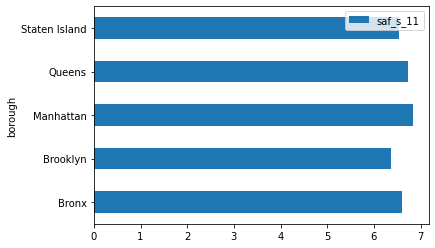

In [105]:
#get the boroughs out, group, and plot

combined['borough']=combined['dbn'].apply(lambda s: s[2:3])
boroughs = {'M': 'Manhattan', 'X': 'Bronx', 'K':'Brooklyn', 'R':'Staten Island', 'Q':'Queens'}
combined['borough']=combined['borough'].map(boroughs)

safety = (combined[['saf_s_11', 'borough']].groupby('borough')
          .agg(numpy.mean)
          .reset_index())

safety.plot.barh(x='borough',y='saf_s_11')

#Safety results by borough

there doesn't appear to be a significant difference when aggregated, Manhattan is highest, Brooklyn is lowest, but all very close to each other

# Racial Differences exploring

<AxesSubplot:>

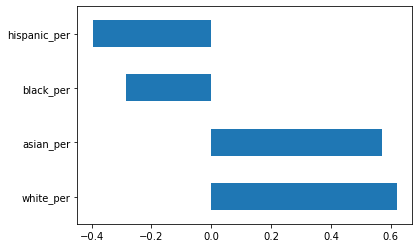

<AxesSubplot:>

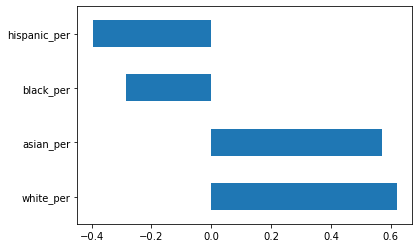

In [106]:
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.barh()

generally higher percentages of asian/white correlate to higher SAT score; higher percentages of hispanic/black correlate to lower SAT score

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

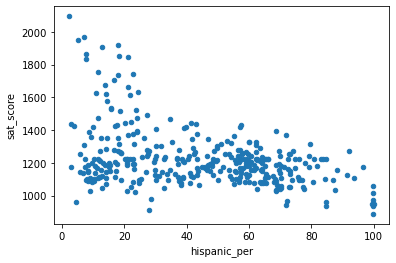

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

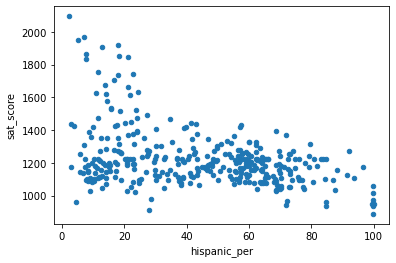

In [107]:
combined.plot.scatter(x='hispanic_per', y = 'sat_score')

there appears to be an inverse relationship that gradually slopes down

In [108]:
combined[combined['hispanic_per']>95]['Name']

44     MANHATTAN BRIDGES HIGH SCHOOL                   
82     WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MAT
125    ACADEMY FOR LANGUAGE AND TECHNOLOGY             
141    INTERNATIONAL SCHOOL OF LIBERAL ARTS            
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253    MULTICULTURAL HIGH SCHOOL                       
286    PAN AMERICAN INTERNATIONAL HIGH SCHOOL          
Name: Name, dtype: object

44     MANHATTAN BRIDGES HIGH SCHOOL                   
82     WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MAT
125    ACADEMY FOR LANGUAGE AND TECHNOLOGY             
141    INTERNATIONAL SCHOOL OF LIBERAL ARTS            
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253    MULTICULTURAL HIGH SCHOOL                       
286    PAN AMERICAN INTERNATIONAL HIGH SCHOOL          
Name: Name, dtype: object

most of these schools provide schooling for immigrants, in particular new immigrants and those from latin america countries

In [109]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1600)]['Name']

37     STUYVESANT HIGH SCHOOL                          
151    BRONX HIGH SCHOOL OF SCIENCE                    
187    BROOKLYN TECHNICAL HIGH SCHOOL                  
327    QUEENS HIGH SCHOOL FOR SCIENCES AT YORK COLLEGE 
356    STATEN ISLAND TECHNICAL HIGH SCHOOL             
Name: Name, dtype: object

37     STUYVESANT HIGH SCHOOL                          
151    BRONX HIGH SCHOOL OF SCIENCE                    
187    BROOKLYN TECHNICAL HIGH SCHOOL                  
327    QUEENS HIGH SCHOOL FOR SCIENCES AT YORK COLLEGE 
356    STATEN ISLAND TECHNICAL HIGH SCHOOL             
Name: Name, dtype: object

All these schools are specialized high schools, and require taking "Specialized High Schools Admissions Test."

# Looking at correlations between genders and sat score

<AxesSubplot:>

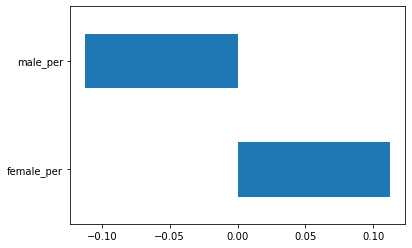

<AxesSubplot:>

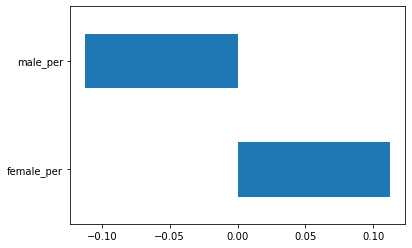

In [110]:
correlations[['female_per','male_per']].plot.barh()

There appears to be a small negative correlation for male percentage, and a small positive correlation for female

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

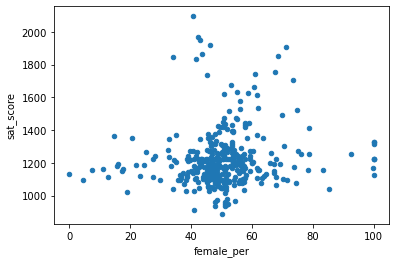

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

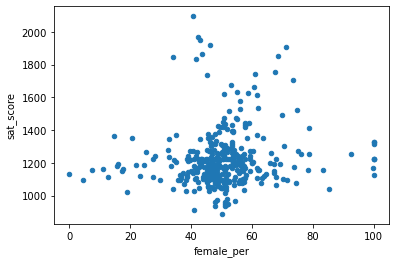

In [111]:
combined.plot.scatter(x='female_per', y='sat_score')

This appears to have a relatively "normal"-looking distribution, with highest scores for schools between 35% and 75% range.

In [112]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['Name']

5      BARD HIGH SCHOOL EARLY COLLEGE                  
26     ELEANOR ROOSEVELT HIGH SCHOOL                   
60     BEACON HIGH SCHOOL                              
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART
302    TOWNSEND HARRIS HIGH SCHOOL                     
Name: Name, dtype: object

5      BARD HIGH SCHOOL EARLY COLLEGE                  
26     ELEANOR ROOSEVELT HIGH SCHOOL                   
60     BEACON HIGH SCHOOL                              
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART
302    TOWNSEND HARRIS HIGH SCHOOL                     
Name: Name, dtype: object

These are all very 'strong', very selective schools, in direct competition with "specialized" high schools. Take admissions from across NYC.

# Looking at AP

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

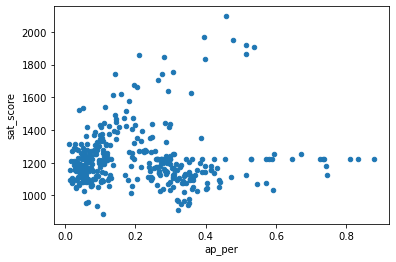

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

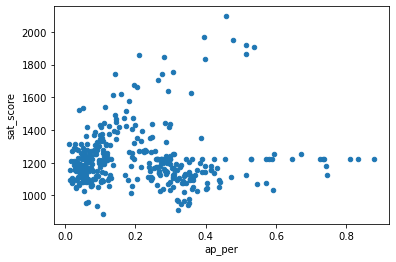

In [113]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y = 'sat_score')

There appears to be a very intersting situation whereby there are two directions - one appears to be trending up with the AP percentage,
but another appears to "ceiling out" at around 1200-1300

# ***Looking further on my own - I am interested in looking at how differences in responses to survery saffect the score

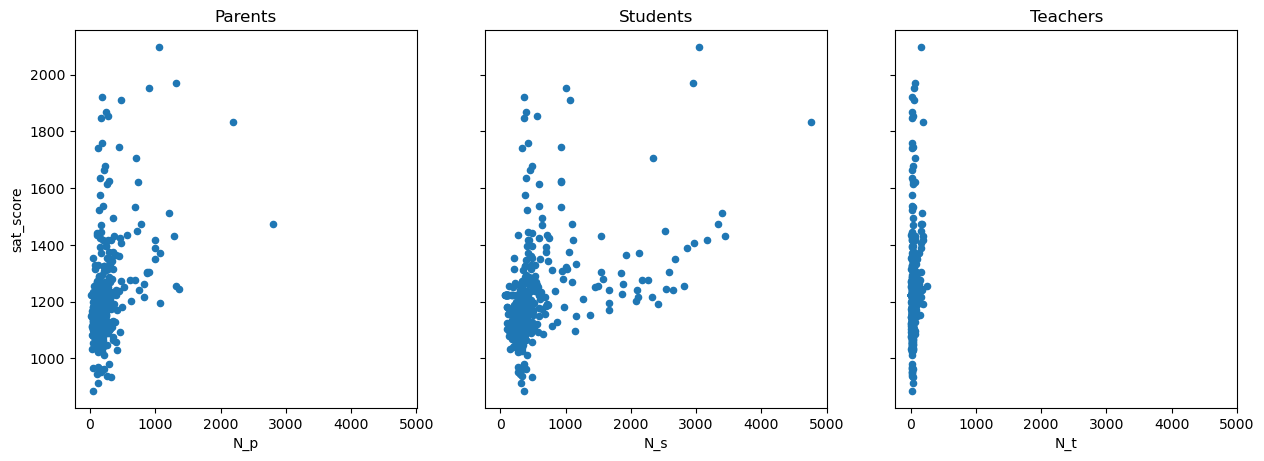

In [139]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, sharex = 'all', sharey = 'all')
fig.set_dpi(100)
fig.set_size_inches(15,5)
combined.plot.scatter(x='N_p', y = 'sat_score', ax =axes[0])
axes[0].set_title("Parents")

combined.plot.scatter(x='N_s', y = 'sat_score', ax =axes[1])
axes[1].set_title("Students")

combined.plot.scatter(x='N_t', y = 'sat_score', ax =axes[2])
axes[2].set_title("Teachers")
plt.show()

This visualization is showing a correlation that's most pronounced for students. There is some correlation for the parents as well
Teachers raw number doesn't appear to be very helpful. But we have to keep in mind that there are less teachers altogether.
Let's repeat the teachers one on its own

<AxesSubplot:xlabel='N_t', ylabel='sat_score'>

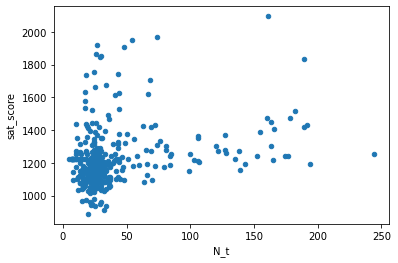

<AxesSubplot:xlabel='N_t', ylabel='sat_score'>

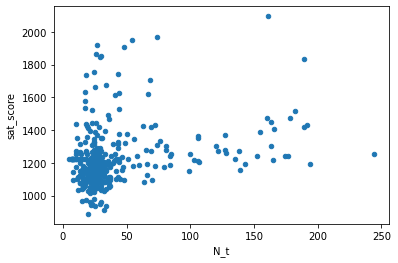

In [115]:
combined.plot.scatter(x='N_t', y = 'sat_score')

Here we note that there appears to be again a group of schools where a small cluster appears to ahve a very weak positive correlation

Let's switch and look at response rate, which (presumably) has adjusted for differences in sizes of the groups (parents, students, teachers) between schools

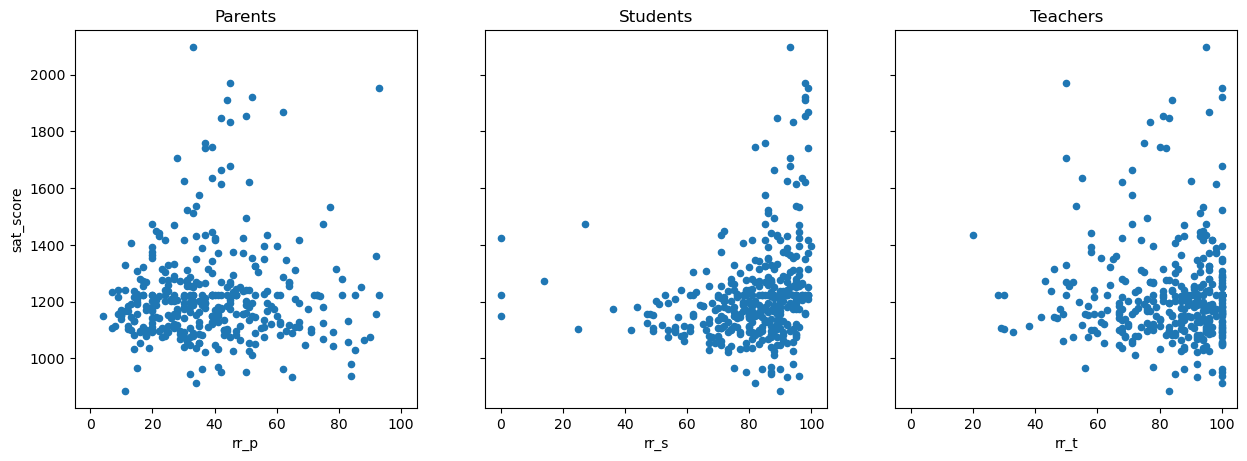

In [140]:
fig, axes = plt.subplots(1,3, sharex = 'all', sharey = 'all')
fig.set_dpi(100)
fig.set_size_inches(15,5)
combined.plot.scatter(x='rr_p', y = 'sat_score', ax =axes[0])
axes[0].set_title("Parents")

combined.plot.scatter(x='rr_s', y = 'sat_score', ax =axes[1])
axes[1].set_title("Students")

combined.plot.scatter(x='rr_t', y = 'sat_score', ax =axes[2])
axes[2].set_title("Teachers")
plt.show()

Looking here, it appears as if teachers and parents not much correlation (at least visually). With students it appears to increase but only slightly
note correlations

In [117]:
correlations[['rr_s', 'rr_t', 'rr_p']]

rr_s    0.232199
rr_t   -0.023386
rr_p    0.047925
Name: sat_score, dtype: float64

rr_s    0.232199
rr_t   -0.023386
rr_p    0.047925
Name: sat_score, dtype: float64

# Let's switch gears and look at effect of School Size vs SAT scores

In [118]:
#let's see what the corr # is, and examine it visually
correlations[['total_enrollment']]

total_enrollment    0.367857
Name: sat_score, dtype: float64

total_enrollment    0.367857
Name: sat_score, dtype: float64

<AxesSubplot:xlabel='total_enrollment', ylabel='sat_score'>

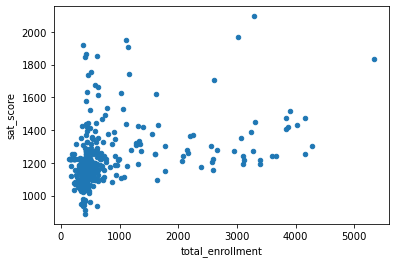

<AxesSubplot:xlabel='total_enrollment', ylabel='sat_score'>

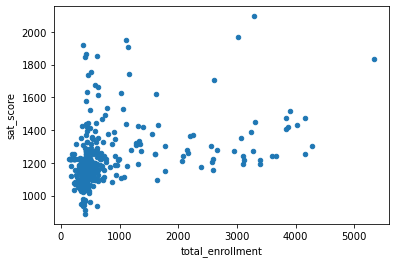

In [119]:
combined.plot.scatter(x='total_enrollment', y = 'sat_score')

It appears that once a school crosses a threshold of about 1000 pupils or so there is some positive correlation.
This is surprising, as would expect that a bigger school would not be doing better as students will likely have less attention
Do bigger schools have lower student:teacher ratio?
Do bigger schools have more programs?

Let's explore in that direction a little more. First let's have a look at what we have for teacher total numbers

## Impact of Teachers - Total and Ratio

In [120]:
# nr_t column doesn't exist in this dataset. It's unclear why. but we have the response rate, so we can impute in the total # of teachers by deviding the number of responses by the response ratio.

combined['nr_t']=combined['N_t']/(combined['rr_t']/100)
combined['nr_t'].describe()
#we need to round the teacher number, as we can't 'really' have a fraction of a teacher
combined['nr_t']=combined['nr_t'].round().astype(int)
combined['nr_t'].describe()

count    363.000000
mean      48.234160
std       46.332843
min        5.000000
25%       25.000000
50%       32.000000
75%       45.500000
max      280.000000
Name: nr_t, dtype: float64

count    363.000000
mean      48.234160
std       46.332843
min        5.000000
25%       25.000000
50%       32.000000
75%       45.500000
max      280.000000
Name: nr_t, dtype: float64

In [121]:
combined['nr_t'].corr(combined['sat_score'])

0.30593411700941747

0.30593411700941747

<AxesSubplot:xlabel='nr_t', ylabel='sat_score'>

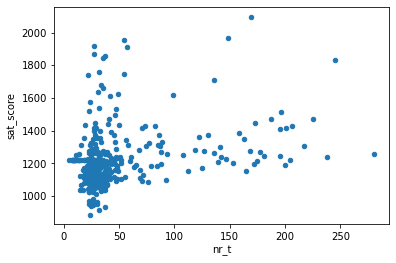

<AxesSubplot:xlabel='nr_t', ylabel='sat_score'>

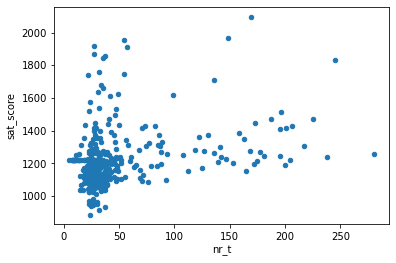

In [122]:
combined.plot.scatter(x='nr_t', y = 'sat_score')

the total number of teachers appears to have a strong positive correlation. Looking at the chart, it does appear that altough there is a predominant group where the amount of teachers doesn't change things much, it does appear that higher teacher numbers do have an effect.

Let's calculate another metric: student-to-teacher ratio. There is a "Schoolwide pupil-teacher ratio" metric, let's see what it's all about


In [123]:
combined['SCHOOLWIDE PUPIL-TEACHER RATIO'].describe()

count    363.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: SCHOOLWIDE PUPIL-TEACHER RATIO, dtype: float64

count    363.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: SCHOOLWIDE PUPIL-TEACHER RATIO, dtype: float64

there is no data. We will impute this

In [124]:
combined['SCHOOLWIDE PUPIL-TEACHER RATIO']=combined['total_enrollment']/combined['nr_t']
combined['SCHOOLWIDE PUPIL-TEACHER RATIO'].describe()

count    363.000000
mean      15.966531
std        3.189108
min        8.285714
25%       13.945517
50%       15.673913
75%       17.735098
max       31.000000
Name: SCHOOLWIDE PUPIL-TEACHER RATIO, dtype: float64

count    363.000000
mean      15.966531
std        3.189108
min        8.285714
25%       13.945517
50%       15.673913
75%       17.735098
max       31.000000
Name: SCHOOLWIDE PUPIL-TEACHER RATIO, dtype: float64

That looks better!
Let's check the correlation with the SAT score

In [125]:
combined['SCHOOLWIDE PUPIL-TEACHER RATIO'].corr(combined['sat_score'])

0.37848972872754344

0.37848972872754344

There is positive correlation. This is surprising, as we would expect higher student:teacher ratio to yield a worse SAT result.
let's look at the data more closely

<AxesSubplot:xlabel='SCHOOLWIDE PUPIL-TEACHER RATIO', ylabel='sat_score'>

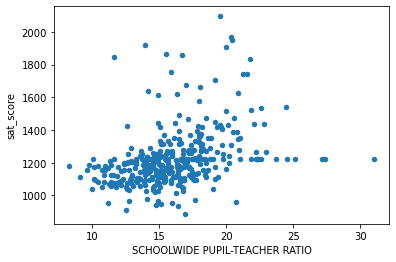

<AxesSubplot:xlabel='SCHOOLWIDE PUPIL-TEACHER RATIO', ylabel='sat_score'>

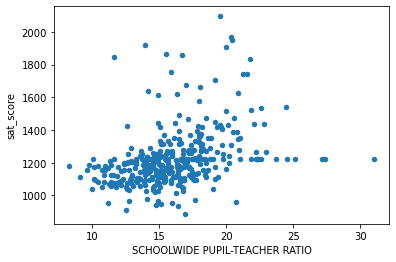

In [126]:
combined.plot.scatter(x='SCHOOLWIDE PUPIL-TEACHER RATIO', y='sat_score')

It looks like early on there are many schools "all over" in terms of scores, and then it tapers off.
There are a few schools with almsot a 1:10 ratio, we will investigate them in more detail

In [127]:
combined[['Name','SCHOOLWIDE PUPIL-TEACHER RATIO']].sort_values(by='SCHOOLWIDE PUPIL-TEACHER RATIO',ascending=False).head()

,Name,SCHOOLWIDE PUPIL-TEACHER RATIO
111,BRONX BRIDGES HIGH SCHOOL,31.000000
59,FRANK MCCOURT HIGH SCHOOL,27.375000
178,BRONX CAREER AND COLLEGE PREPARATORY HIGH SCHOOL,27.111111
33,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,25.142857
326,QUEENS METROPOLITAN HIGH SCHOOL,24.555556


,Name,SCHOOLWIDE PUPIL-TEACHER RATIO
111,BRONX BRIDGES HIGH SCHOOL,31.000000
59,FRANK MCCOURT HIGH SCHOOL,27.375000
178,BRONX CAREER AND COLLEGE PREPARATORY HIGH SCHOOL,27.111111
33,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,25.142857
326,QUEENS METROPOLITAN HIGH SCHOOL,24.555556


It makes sense why the school student:teacher ratio is so high for the top school - it's american sign language school which likely
requires specialised approach to students.
The other schools in this list appear to have a very specific focus on global studies, it's unclear how this factors into overall education quality, as SAT is an imperfect metric.
It appears that the assumption of higher student:teacher ratio resulting in worse outcome is not consistent with this data (at least on a superficial level)
However, the overall number of teachers does have some signalling in terms of higher SAT scores

## Class size

In [128]:
combined['AVERAGE CLASS SIZE'].corr(combined['sat_score'])

0.3810143308095524

0.3810143308095524

Positive correlation, which again is a bit strange. There is likely an underlying factor of some sort
which explains why larger schools and schools with larger class sizes tend to do better
One possible explanation is that there are more activities and opportunities in larger schools
Here is the scatter

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

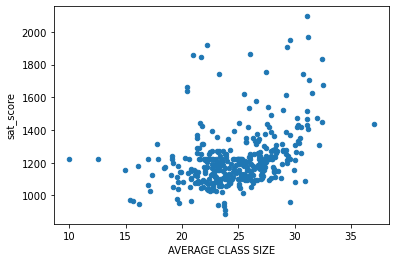

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

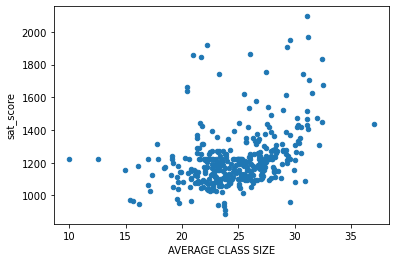

In [129]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y = 'sat_score')

Similar to higher teacher:student ratio, higher class size isn't a detriment
There are a few outlieres -

In [130]:
sorted_class = combined[['Name','AVERAGE CLASS SIZE']].sort_values(by='AVERAGE CLASS SIZE',ascending=False)
sorted_class.head()

,Name,AVERAGE CLASS SIZE
17,NYCISCHOOL,37.023077
24,NYC LAB SCHOOL FOR COLLABORATIVE STUDIES,32.566667
187,BROOKLYN TECHNICAL HIGH SCHOOL,32.452632
307,BAYSIDE HIGH SCHOOL,32.405263
29,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN SER,32.187500


,Name,AVERAGE CLASS SIZE
17,NYCISCHOOL,37.023077
24,NYC LAB SCHOOL FOR COLLABORATIVE STUDIES,32.566667
187,BROOKLYN TECHNICAL HIGH SCHOOL,32.452632
307,BAYSIDE HIGH SCHOOL,32.405263
29,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN SER,32.187500


In [131]:
sorted_class.tail()

,Name,AVERAGE CLASS SIZE
126,BRONX INTERNATIONAL HIGH SCHOOL,15.611111
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,15.361538
8,HIGH SCHOOL FOR HISTORY & COMMUNICATION,14.900000
264,URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE,12.575000
56,THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS,10.000000


,Name,AVERAGE CLASS SIZE
126,BRONX INTERNATIONAL HIGH SCHOOL,15.611111
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,15.361538
8,HIGH SCHOOL FOR HISTORY & COMMUNICATION,14.900000
264,URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE,12.575000
56,THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS,10.000000


The school with the largest class size is NYC iSchool, which is a relatively new school. They have mixed classes (explains larger class size potentially) and a different
"vision" with a focus on skills, which explains why a standardized test like SAT might not directly reflect the educaitonal experience

School with the smallest average class size appear to be very specialized schools as well.

# Assign overall score to a school - from academic standpoint

There are many ways a school can be ranked, depending on what one considers important.
In this dataset, the following "academic" metrics are potentially relevant:

sat_score (standardized college admissions test)

AP pass rate (which can be calculated from total AP exams taken divided by those with a "passing" score (i.e. 3, 4, 5))
Regents % (standardized high school exams)

There are additional quantitative metrics (ex. Advanced Regents) and various qualitative metrics (which are harder to analyze)

It's difficult to assign the "weight" of these. A simple approach would be to give each one of these equivalent weight
for those where a score is "0" in a column weights will need to be adjusted - the SAT score will then compensate for a deficient score

We will have to go back to a dataset where mean score was not filled in, and account for it during calculations (i.e. avoid divide-by-zero issues)

In [132]:
#calcualte AP pass rate
combined2 = data["sat_results"]

combined2 = combined2.merge(data["ap_2010"], on="DBN", how="left")
combined2 = combined2.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined2 = combined2.merge(data[m], on="DBN", how="inner")

#will need to drop all the columns where sat score is "NA". Generally if the school has AP data it would have SAT as well
combined2 = combined2.dropna(subset=['sat_score'])

In [133]:
#calculate AP exam pass rate.
combined2['ap_pass_rate']=combined2['Number of Exams with scores 3 4 or 5']/combined2['Total Exams Taken']

In [134]:
#assign a cumulative score to a school based on STDEV from mean score for sat_score, AP exam pass rate, % Regents

#calculate the means, deviations, then impute in the SAT for when there are no values
mean_sat = combined2['sat_score'].mean()
stdev_sat = combined2['sat_score'].std()

mean_ap = combined2['ap_pass_rate'].mean()
stdev_ap = combined2['ap_pass_rate'].std()

combined2['Total Regents - % of grads'] = pd.to_numeric(combined2['Total Regents - % of grads'].str.slice(start=0, stop=-1), errors='coerce')
mean_regents = combined2['Total Regents - % of grads'].mean()
stdev_regents = combined2['Total Regents - % of grads'].std()

In [135]:
#this should always calculate because we dropped all rows with no SAT score
combined2['sat_dev']=(combined2['sat_score']-mean_sat)/stdev_sat
combined2['ap_dev']=(combined2['ap_pass_rate']-mean_ap)/stdev_ap
combined2['regent_dev']=(combined2['Total Regents - % of grads']-mean_regents)/stdev_regents

In [137]:
#fill in the gaps in ap_dev and regent_dev using SAT
combined2['subbed_ap_dev']=combined2['ap_dev'].fillna(value=combined2['sat_dev'])
combined2['subbed_regent_dev']=combined2['regent_dev'].fillna(value=combined2['sat_dev'])

In [147]:
#overall score, then sort, and print out top 10 schools
combined2['total_score']=combined2['sat_dev']+combined2['subbed_ap_dev']+combined2['subbed_regent_dev']

sorted_schools = combined2[['Name', 'total_score']].sort_values(by='total_score', ascending=False)
sorted_schools.reset_index(inplace=True)

sorted_schools.head(10)

,index,Name,total_score
0,37,STUYVESANT HIGH SCHOOL,8.393446
1,5,BARD HIGH SCHOOL EARLY COLLEGE,8.186747
2,151,BRONX HIGH SCHOOL OF SCIENCE,7.529023
3,356,STATEN ISLAND TECHNICAL HIGH SCHOOL,7.420275
4,198,BROOKLYN LATIN,6.936369
5,155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG,6.844393
6,302,TOWNSEND HARRIS HIGH SCHOOL,6.703749
7,327,QUEENS HIGH SCHOOL FOR SCIENCES AT YORK COLLEGE,6.604140
8,287,BARD HIGH SCHOOL EARLY COLLEGE II,6.106377
9,187,BROOKLYN TECHNICAL HIGH SCHOOL,6.032935
